In [1]:
# import packages for visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from map_plan import *

In [4]:
sample_map = create_sample_map()
obstacle_map = sample_map[:,:,0]
goal_map = sample_map[:,:,1]
current_pos_map = sample_map[:,:,2]

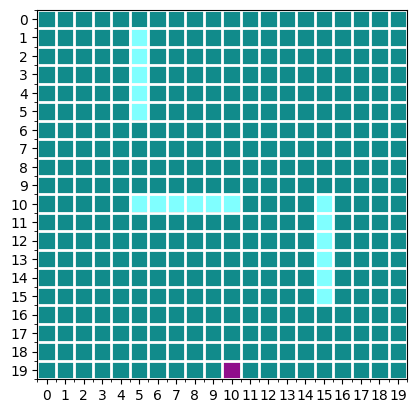

In [5]:
ax = plot_soft_position(obstacle_map, cmap='hot', alpha=0.9)
ax = plot_soft_position(goal_map, cmap='cool', alpha=0.5, ax=ax)

(tensor(0.), tensor(0.))
(tensor(0.2921), tensor(0.2921))


/Users/kyunghyuncho/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


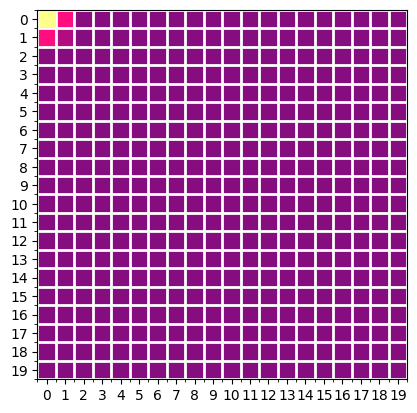

In [6]:
current_coord = get_hard_position(current_pos_map)
print(current_coord)
current_soft_map = get_soft_position(current_coord[0], current_coord[1])
current_soft_coord = get_hard_position(current_soft_map)
print(current_soft_coord)

ax = plot_soft_position(current_pos_map, cmap='spring', alpha=0.9)
ax = plot_soft_position(current_soft_map, cmap='hot', alpha=0.5, ax=ax)

(tensor(8.0000), tensor(8.))


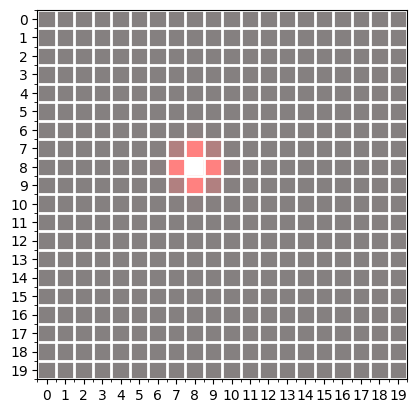

In [7]:
current_soft_map = get_soft_position(8, 8)
current_soft_coord = get_hard_position(current_soft_map)
print(current_soft_coord)

ax = plot_soft_position(current_soft_map, cmap='hot', alpha=0.5)

In [26]:
# perform gradient descent on the trajectory
# the beginning is the current position
trajectory_length = 20
trajectory = torch.zeros(trajectory_length, 2)
trajectory[0] = torch.tensor(get_hard_position(current_pos_map, argmax=True))

# randomly initialize the rest of the steps of `trajectory`
for i in range(1, trajectory_length):
    trajectory[i] = torch.tensor([np.random.randint(0, obstacle_map.shape[0]), 
                                  np.random.randint(0, obstacle_map.shape[0])])

n_steps = 1000
learning_rate = 0.1

for step in range(n_steps):
    trajectory = trajectory.clone().detach()
    trajectory.requires_grad = True
    trajectory.grad = None

    score = score_trajectory(trajectory, obstacle_map, goal_map, current_pos_map,
                             distance_coeff=10.0, 
                             collision_coeff=150.0, 
                             smoothness_coeff=10., 
                             distance_from_current_coeff=10.0)
    score.backward()

    trajectory = trajectory - learning_rate * trajectory.grad

    if step % 10 == 0:
        print(f'Step {step+1} Score {score.item()}')

trajectory = trajectory.detach()

Step 1 Score 870.300048828125
Step 11 Score 528.2874755859375
Step 21 Score 323.5643615722656
Step 31 Score 224.2438507080078
Step 41 Score 178.14715576171875
Step 51 Score 162.76095581054688
Step 61 Score 155.13819885253906
Step 71 Score 157.1898956298828
Step 81 Score 139.324462890625
Step 91 Score 115.10620880126953
Step 101 Score 105.31790161132812
Step 111 Score 104.88601684570312
Step 121 Score 108.23533630371094
Step 131 Score 101.8249740600586
Step 141 Score 101.97386169433594
Step 151 Score 99.42454528808594
Step 161 Score 97.221923828125
Step 171 Score 95.22723388671875
Step 181 Score 93.33161163330078
Step 191 Score 91.779541015625
Step 201 Score 90.26396179199219
Step 211 Score 88.84789276123047
Step 221 Score 87.4107666015625
Step 231 Score 85.86378479003906
Step 241 Score 84.15972137451172
Step 251 Score 82.36151123046875
Step 261 Score 80.61959838867188
Step 271 Score 79.03939819335938
Step 281 Score 77.64240264892578
Step 291 Score 76.39112854003906
Step 301 Score 75.25

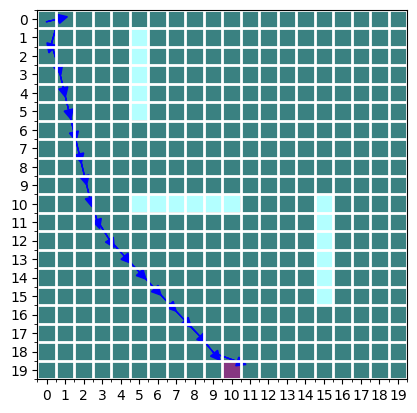

In [27]:
# plot the trajectory
ax = plot_soft_position(obstacle_map, cmap='hot', alpha=0.7)
ax = plot_soft_position(goal_map, cmap='cool', alpha=0.3, ax=ax)
for i in range(trajectory_length):
    if i > 0:
        # draw an arrow from the previous point to the current poin in the trajectory.
        ax.arrow(trajectory[i-1, 1], trajectory[i-1, 0], 
                 trajectory[i, 1]-trajectory[i-1, 1], 
                 trajectory[i, 0]-trajectory[i-1, 0], 
                 head_width=0.5, head_length=0.5, fc='b', ec='b')